# 최적 학습률 찾기 및 시각화

- 학습률 찾기(Learning Rate Finder) 기법을 사용하여 최적 학습률을 찾고,
- 최적 학습률을 사용하여 모델을 재학습한 후 학습 과정의 손실과 정확도를 시각화하여 비교.

## 1. 라이브러리 임포트 및 데이터셋 로드

- 필요한 라이브러리를 임포트하고, 와인 데이터셋을 로드하여 특성(X)과 타겟(y)으로 분리합니다.
- 타겟을 원-핫 인코딩으로 변환하여 분류 문제에 적합하게 만듭니다.
- 데이터를 학습 세트와 테스트 세트로 분할합니다.
- `StandardScaler`를 사용하여 데이터를 정규화합니다.

In [1]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

# 데이터셋 로드
wine = load_wine()
X = wine.data
y = wine.target

# 타겟을 원-핫 인코딩으로 변환
y = tf.keras.utils.to_categorical(y)

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 정규화 (평균 0, 표준편차 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. 모델 정의

- `create_model()` 함수를 정의하여 신경망 모델을 생성합니다.
- 모델은 입력층, 은닉층 2개, 드롭아웃 층, 출력층으로 구성됩니다.

In [2]:
# 모델 정의
def create_model():
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    return model

In [9]:
# 모델 컴파일 및 학습
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 2s 145ms/step - loss: 1778769295572992.0000 - accuracy: 0.3717 - val_loss: 246401602682880.0000 - val_accuracy: 0.3448
Epoch 2/100
4/4 [==============================] - 0s 37ms/step - loss: 156747801034752.0000 - accuracy: 0.3009 - val_loss: 796058.0625 - val_accuracy: 0.6552
Epoch 3/100
4/4 [==============================] - 0s 45ms/step - loss: 200640722632704.0000 - accuracy: 0.6991 - val_loss: 480156909043712.0000 - val_accuracy: 0.4138
Epoch 4/100
4/4 [==============================] - 0s 41ms/step - loss: 183972642422784.0000 - accuracy: 0.3363 - val_loss: 2977.4062 - val_accuracy: 0.3103
Epoch 5/100
4/4 [==============================] - 0s 25ms/step - loss: 2401.9570 - accuracy: 0.3097 - val_loss: 1778.4299 - val_accuracy: 0.4138
Epoch 6/100
4/4 [==============================] - 0s 29ms/step - loss: 1689.4912 - accuracy: 0.3982 - val_loss: 863.9227 - val_accuracy: 0.4138
Epoch 7/100
4/4 [==============================] - 0s 2

2/2 [==============================] - 0s 7ms/step - loss: 297.8618 - accuracy: 0.3889
테스트 세트의 정확도: 0.3888888955116272


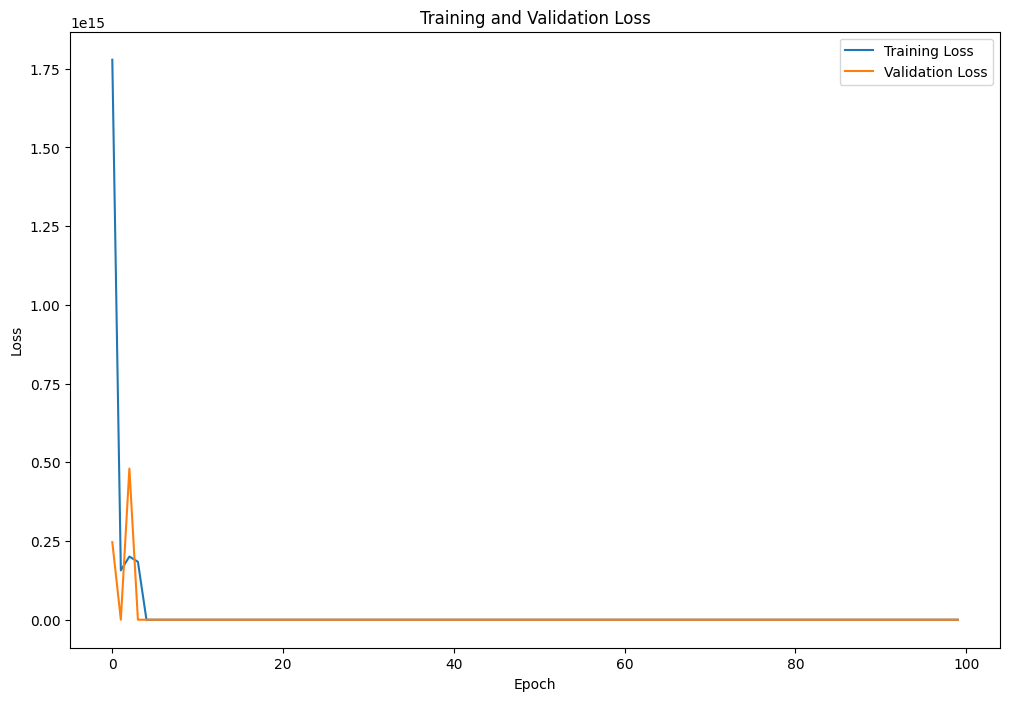

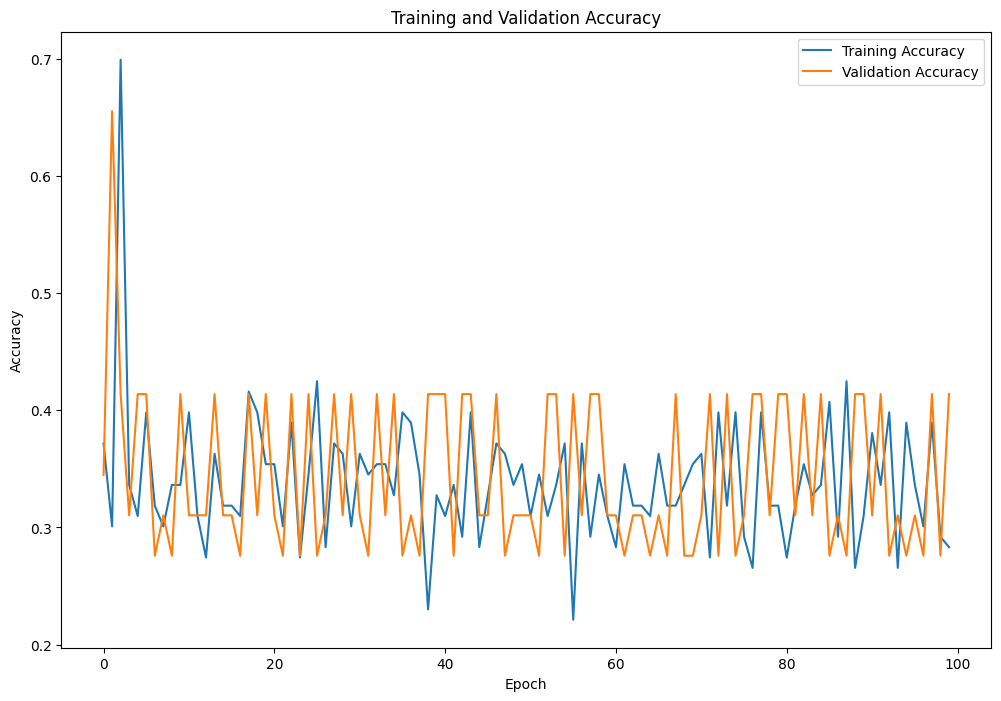

In [10]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"테스트 세트의 정확도: {accuracy}")

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## 3. Learning Rate Finder 콜백 정의

- `LearningRateFinder` 콜백 클래스를 정의합니다. 이 클래스는 학습률을 지수적으로 증가시키면서 각 배치의 손실을 기록합니다.
- `on_train_batch_end` 메서드는 각 배치가 끝날 때 호출되어 현재 학습률과 손실을 기록하고, 손실이 너무 커지면 학습을 중지합니다.

In [15]:
# Learning Rate Finder 콜백
class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=1, steps=10):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lr_mult = (max_lr / min_lr) ** (1 / steps)
        self.lrs = []
        self.losses = []
        self.best_loss = float('inf')

    def on_train_batch_end(self, batch, logs=None):
        lr = self.min_lr * (self.lr_mult ** len(self.losses))
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.lrs.append(lr)
        loss = logs['loss']
        self.losses.append(loss)
        if len(self.losses) > 1 and loss > self.best_loss * 10:
            self.model.stop_training = True
        if loss < self.best_loss:
            self.best_loss = loss


## 4. 모델 컴파일 및 학습

- 모델을 컴파일하고, `LearningRateFinder` 콜백을 사용하여 학습을 진행합니다.
- 학습률과 손실 값을 기록합니다.

In [16]:
# 모델 컴파일 및 학습
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Finder 실행
lr_finder = LearningRateFinder(min_lr=1e-6, max_lr=1, steps=20)
model.fit(X_train, y_train, epochs=1, batch_size=16, callbacks=[lr_finder])

9/9 [==============================] - 1s 3ms/step - loss: 1.1922 - accuracy: 0.1972


## 5. 학습률과 손실 시각화

- 기록된 학습률과 손실 값을 시각화하여 최적 학습률을 찾습니다.

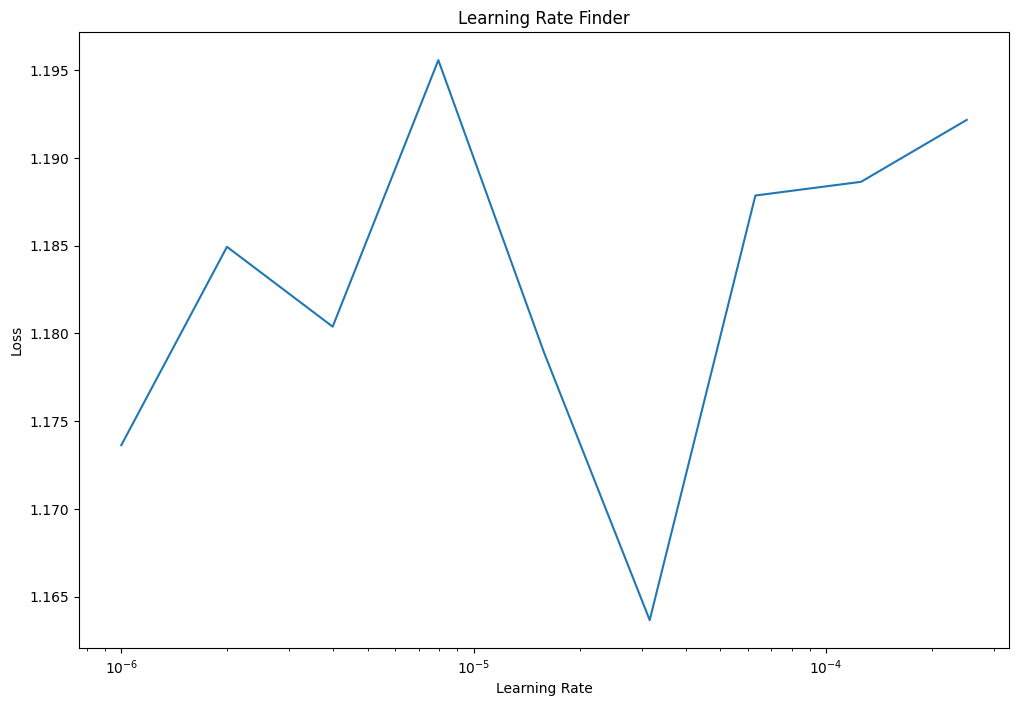

In [17]:
# 학습률과 손실 시각화
plt.figure(figsize=(12, 8))
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.show()

## 6. 최적 학습률 추정

- `find_best_lr` 함수를 사용하여 손실이 가장 작은 학습률을 추정합니다.


In [18]:
# 최적 학습률 추정
def find_best_lr(lrs, losses):
    min_loss_idx = np.argmin(losses)
    best_lr = lrs[min_loss_idx]
    return best_lr

best_lr = find_best_lr(lr_finder.lrs, lr_finder.losses)
print(f'Best learning rate: {best_lr}')


Best learning rate: 3.16227766016838e-05


## 7. 최적 학습률로 모델 재학습

- 최적 학습률을 사용하여 모델을 재정의하고 재학습합니다.
- 학습 과정의 손실과 정확도를 기록합니다.

In [19]:
# 최적 학습률로 모델 재학습
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
4/4 [==============================] - 1s 80ms/step - loss: 1.1331 - accuracy: 0.3628 - val_loss: 1.1505 - val_accuracy: 0.2759
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 1.1293 - accuracy: 0.3628 - val_loss: 1.1472 - val_accuracy: 0.2759
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 1.1257 - accuracy: 0.3982 - val_loss: 1.1440 - val_accuracy: 0.2759
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 1.1221 - accuracy: 0.3982 - val_loss: 1.1408 - val_accuracy: 0.2759
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 1.1187 - accuracy: 0.3982 - val_loss: 1.1377 - val_accuracy: 0.2759
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1150 - accuracy: 0.4071 - val_loss: 1.1346 - val_accuracy: 0.2759
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1117 - accuracy: 0.4071 - val_loss: 1.1314 - val_accuracy: 0.3103
Epoch 8/100
4/4 [===

2/2 [==============================] - 0s 11ms/step - loss: 0.8630 - accuracy: 0.6944
테스트 세트의 정확도: 0.6944444179534912


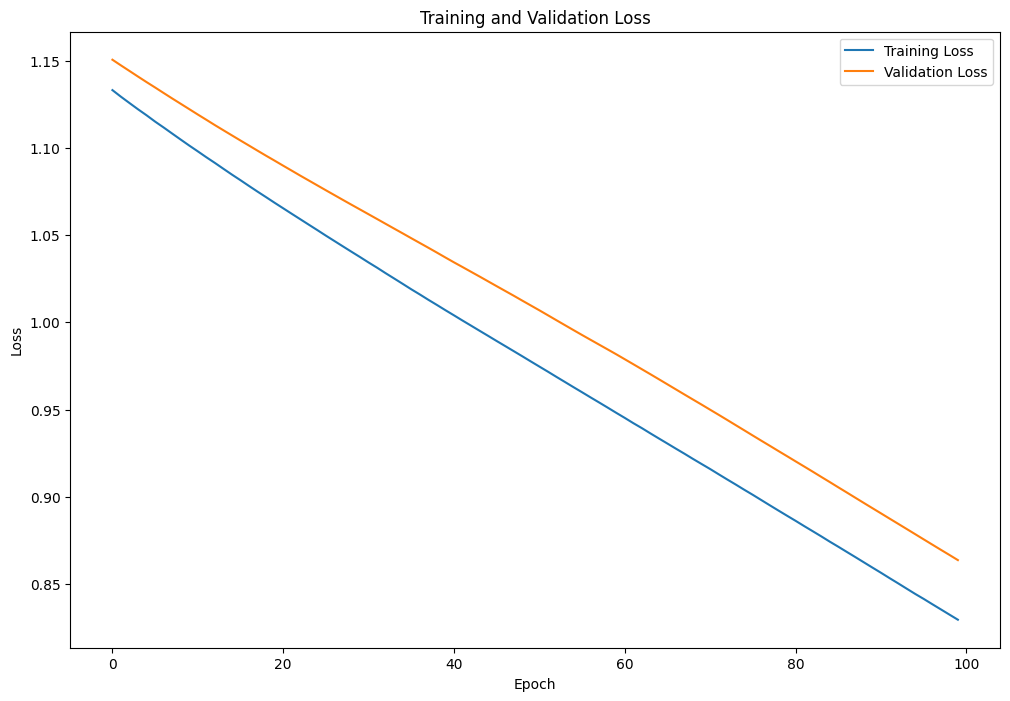

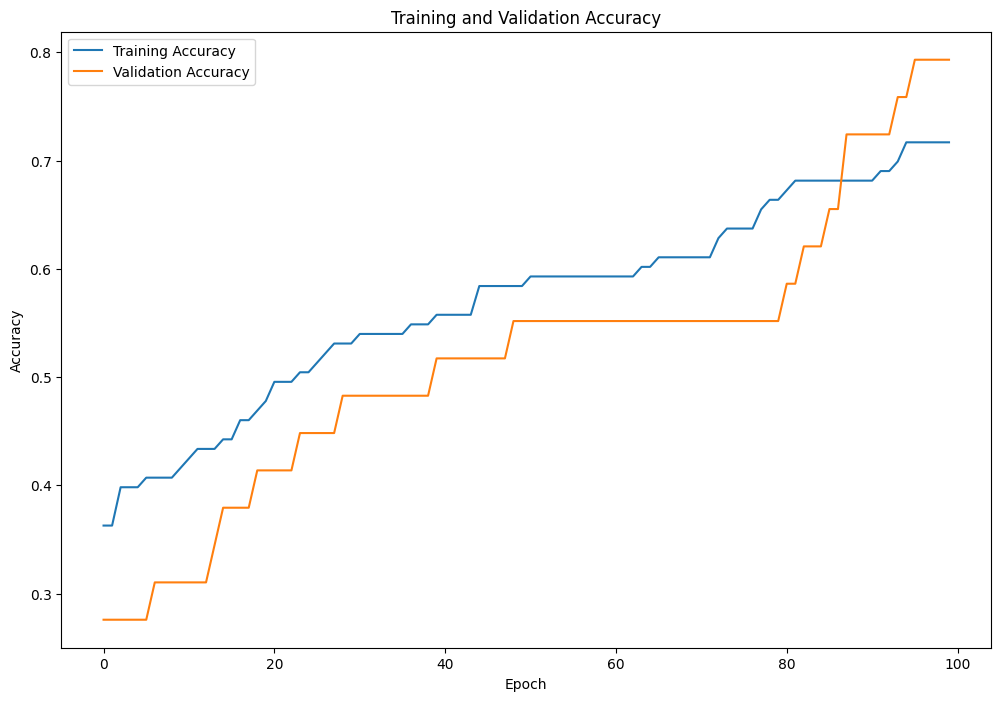

In [20]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"테스트 세트의 정확도: {accuracy}")

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()